# Import libraries + MNIST dataset

In [1]:
# Импортируем необходимые библиотеки
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Загрузим Mnist dataset и посмотрим на размерность наших данных
from tensorflow.keras.datasets import mnist
(trainX, trainy), (testX, testy) = mnist.load_data()

In [3]:
trainX.shape

(60000, 28, 28)

In [4]:
testX.shape

(10000, 28, 28)

In [5]:
# Итого у нас 60 000 картинокв размерностью 28 на 28 пикселей (784 пикселя) - в тренировочном датасете
# И 10 000 картинок в тестовом

In [6]:
# нормализируем наши данные, чтобы сделать результат более устойчивым в числовом выражении, - в этом случае мы просто предпочтем иметь входные данные от 0 до 1
# если мы разделим каждый элемент на 255 (различные варианты цветов), мы получим желаемый результат - все элементы будут между 0 и 1. В каком то смысле, это как feature scalling в нашей нейронной сети

input_shape = (28, 28, 1)

X_train=trainX.reshape(trainX.shape[0], trainX.shape[1], trainX.shape[2], 1)
X_train=X_train / 255.0
X_test = testX.reshape(testX.shape[0], testX.shape[1], testX.shape[2], 1)
X_test=X_test/255.0


print("Number of original training examples:", len(X_train))
print("Number of original test examples:", len(X_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [7]:
number_of_image = X_test.shape[0]
number_of_image

10000

In [8]:
# Посмотрим как выглядят наши данные - выведем полностью случайный массив numpy, а также визуализируем этот массив с помощью matplotlib функции plt.imshow
# Возьмем например 7 рандомных изображений
random_indices = np.random.choice(number_of_image, size=7, replace=False)
random_image = X_test[random_indices, :]

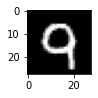

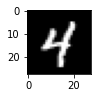

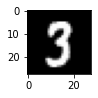

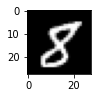

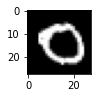

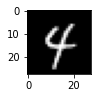

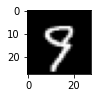

In [9]:
for i in range(7): 
    plt.subplot(330 + 1)
    plt.imshow(np.squeeze(random_image[i]), cmap=plt.get_cmap('gray'))
    plt.show()

In [10]:
# Проверим наш датасет на наличие пустых значений.

In [11]:
np.isnan(X_train).any()

False

In [12]:
np.isnan(X_test).any()

False

In [13]:
# У нас нет пустых значений, все ок.

In [14]:
# Посмотрим на наш таргет
trainy

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

C:\Users\93ttt\anaconda3\envs\tensorflow_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

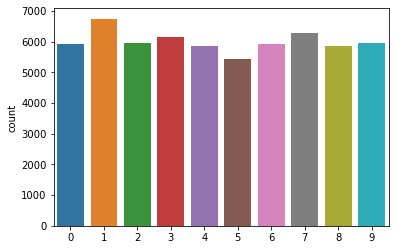

In [15]:
# Таргет сбалансирован, всех цифр от 0 до 9 плюс минус одинаковое количество
sns.countplot(trainy)

In [16]:
# Выполним LabelEncoding нашего таргета, так как на данный момент, метки классов представлены как continuous numbers, не категориальные
# Прибегнем к помощи нашего знакомого метода - One Hot Encoding, который трансформирует таргет в соотвествующие вектора
y_train = trainy.reshape(-1, 1)
y_test = testy.reshape(-1, 1)

In [17]:
from sklearn import preprocessing

encoder_hot = preprocessing.OneHotEncoder()

encoder_hot.fit(y_train)
y_transformed_train = encoder_hot.transform(y_train).toarray()

encoder_hot.fit(y_test)
y_transformed_test = encoder_hot.transform(y_test).toarray()

print(f'Value without encoding: {y_test[123]}')
print(f'Value with encoding: {y_transformed_test[123]}')

Value without encoding: [6]
Value with encoding: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [18]:
# Label Encoding finished.

# Neural Net Basic

In [19]:
# Создадим нейронную сеть с помощью keras (1 слой - Flatten, который распрямляет двумерный массив в одномерный, последний слой Dense(10) c правильной активацией)
# Количество нейронов выберем 128
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

In [20]:
# Предварительно создадим функции ниже для подсчета метрики f1 в нашей модели. По умолчанию не нашел ее в сборке tensorflow. Поэтому решим эту мини проблему вручную.
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [21]:
# Выберем для нашей модели loss функцию - возьмем CategoricalCrossentropy
# Выберем optimiser - Adam, и скомпилируем нашу модель
# Наши качественные метрики - accuracy и f1
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc', f1_m],)

In [22]:
# Гиперпараметр batch_size выберем 32. The batch size is a number of samples processed before the model is updated.
# Гиперпараметр epochs выберем 15. The number of epochs is the number of complete passes through the training dataset.

batch_size =32
epochs = 15
history_1 = model_1.fit(X_train, y_transformed_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1)

Epoch 1/15
1688/1688 [==============================] - 4s 2ms/step - loss: 0.2701 - acc: 0.9221 - f1_m: 0.5389 - val_loss: 0.1313 - val_acc: 0.9645 - val_f1_m: 0.5796
Epoch 2/15
1688/1688 [==============================] - 2s 1ms/step - loss: 0.1206 - acc: 0.9641 - f1_m: 0.5826 - val_loss: 0.0994 - val_acc: 0.9710 - val_f1_m: 0.5806
Epoch 3/15
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0827 - acc: 0.9749 - f1_m: 0.6119 - val_loss: 0.0835 - val_acc: 0.9745 - val_f1_m: 0.6231
Epoch 4/15
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0623 - acc: 0.9809 - f1_m: 0.6296 - val_loss: 0.0810 - val_acc: 0.9747 - val_f1_m: 0.6261
Epoch 5/15
1688/1688 [==============================] - 2s 1ms/step - loss: 0.0490 - acc: 0.9845 - f1_m: 0.6444 - val_loss: 0.0775 - val_acc: 0.9785 - val_f1_m: 0.6301
Epoch 6/15
1688/1688 [==============================] - 2s 1ms/step - loss: 0.0383 - acc: 0.9882 - f1_m: 0.6599 - val_loss: 0.0775 - val_acc: 0.9790 - val_f1_m:

In [23]:
# Точность нашей модели на train около 99.7%, на validation около 98%. F1 = это средневзвешенное значение precision и recall, и у нас оно равно около 75%.

In [24]:
# Оценим нашу модель на тестовом датасете при помощи метода evaluate
print("Evaluate on test data")
results = model_1.evaluate(X_test, y_transformed_test, batch_size=32)
print("test loss, test acc, test mse, f1:", results)

Evaluate on test data
313/313 [==============================] - 0s 1ms/step - loss: 0.0877 - acc: 0.9799 - f1_m: 0.7426
test loss, test acc, test mse, f1: [0.0877360925078392, 0.9799000024795532, 0.7425971627235413]


In [25]:
# Точность базовой модели на тестовом датасете составляет около 98%

In [26]:
# Построим общую confusion matrix в разрезе всех 10 классов
y_pred1 = model_1.predict(X_test)
y_pred_classes1 = np.argmax(y_pred1, axis = 1) 
y_true1 = np.argmax(y_transformed_test, axis = 1)
confusion_mtx1 = tf.math.confusion_matrix(y_true1, y_pred_classes1)

<AxesSubplot:>

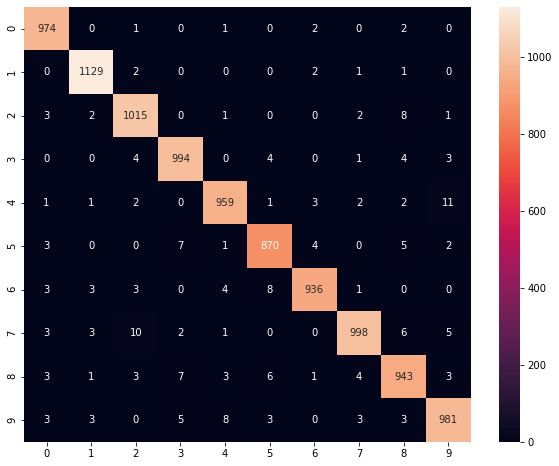

In [27]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx1, annot=True, fmt='g')

In [28]:
# В плане ошибок отметим самые значимые моменты:
# найбольшее количество ошибок у нас в классе 4, 2, 7
# найменьшее количество ошибок у нас в классе 0, 1

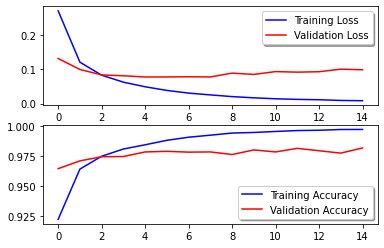

In [29]:
# Построим графики того как меняются значения loss-функции
# Также отметим одно наблюдение, что необходимо полностью перезапускать весь код, так как если выполнять повторно код где модель фитится, то точность подскакивает почти до 100%, моель явно переобучается
fig, ax = plt.subplots(2,1)
ax[0].plot(history_1.history['loss'], color='b', label="Training Loss")
ax[0].plot(history_1.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_1.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(history_1.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [30]:
# Судя по виду графиков loss функции, у нас буквально со второго бетча начинается overfit
# Но для понимания базовой модели подойдет визуализация
# Не будем здесь вникать в подробности, давайте улучшим нашу модель

# Neural Net Experimetation + Dropout Layer + Early stopping

In [103]:
# Первым делом, давайте добавим больше слоев в нашу модель.
# Также добавим слой Dropout - его преимущество в том, что этот слой помогает предотвратить оверфит
# В DropoutLayer мы вводим значение от 0 до 1, которое показывает нам сколько нейронов нужно отбросить из предыдущего слоя. Например если в предыдущем слое было 1000 нейронов, а значение в dropout 0.2, то для следующего слоя в модели отсеятся 200 нейронов и останутся 800. Механика этого процесса помогает уменьшить оверфит
# Также давайте добавим еще один слой Dense
# Поэксперрипнотируем с подбором параметров для нашей модели (batch_size, epochs, количество нейронов с лоях, количество слоев, функции активации, learning rate in ADAM)

# Вынесем все необходимые параметры в отдельные переменные для простоты эксперимента
batch_size = 32
epochs = 10
neurons = 1024
dropout_value = 0.25
learning_rate = 0.001

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(neurons, activation='relu'),
    tf.keras.layers.Dense(neurons, activation='relu'),
    tf.keras.layers.Dropout(dropout_value),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [104]:
# Также добавим в нашу модель параметр Early Stopping, который завершит обучение нашей модели, когда приросты accuracy прекратятся или будут очень маленькими. Это в свою очередь поможет нам избежать оверфит и увеличит производительность нашей модели
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=4, min_delta=0.01, verbose=1)

In [105]:
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc', f1_m])

In [106]:
history_2 = model_2.fit(X_train, y_transformed_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[early_stopping])


Epoch 1/10
1688/1688 [==============================] - 18s 10ms/step - loss: 0.1952 - acc: 0.9416 - f1_m: 0.9404 - val_loss: 0.0899 - val_acc: 0.9718 - val_f1_m: 0.9722
Epoch 2/10
1688/1688 [==============================] - 17s 10ms/step - loss: 0.0900 - acc: 0.9726 - f1_m: 0.9728 - val_loss: 0.1021 - val_acc: 0.9713 - val_f1_m: 0.9727
Epoch 3/10
1688/1688 [==============================] - 17s 10ms/step - loss: 0.0629 - acc: 0.9803 - f1_m: 0.9806 - val_loss: 0.0727 - val_acc: 0.9787 - val_f1_m: 0.9797
Epoch 4/10
1688/1688 [==============================] - 17s 10ms/step - loss: 0.0497 - acc: 0.9846 - f1_m: 0.9847 - val_loss: 0.0921 - val_acc: 0.9775 - val_f1_m: 0.9781
Epoch 5/10
1688/1688 [==============================] - 17s 10ms/step - loss: 0.0436 - acc: 0.9868 - f1_m: 0.9869 - val_loss: 0.0763 - val_acc: 0.9805 - val_f1_m: 0.9808
Epoch 6/10
1688/1688 [==============================] - 17s 10ms/step - loss: 0.0350 - acc: 0.9892 - f1_m: 0.9894 - val_loss: 0.0878 - val_acc: 0.9802

In [107]:
# Оценим нашу модель на тестовом датасете при помощи метода evaluate
print("Evaluate on test data")
results2 = model_2.evaluate(X_test, y_transformed_test)
print("test loss, test acc, test mse, f1:", results2)

Evaluate on test data
313/313 [==============================] - 1s 4ms/step - loss: 0.1065 - acc: 0.9792 - f1_m: 0.9795
test loss, test acc, test mse, f1: [0.10647112876176834, 0.979200005531311, 0.9795293211936951]


In [108]:
# Точность нашей модели на тестовом датасете составляет также около 98%, однако f1 у нас вырос до 99%. Точность на train упала до 99%, точность на validation остается на уровне оклоло 98%

In [109]:
# Построим общую confusion matrix в разрезе всех 10 классов
y_pred2 = model_2.predict(X_test)
y_pred_classes2 = np.argmax(y_pred2, axis = 1) 
y_true2 = np.argmax(y_transformed_test, axis = 1)
confusion_mtx2 = tf.math.confusion_matrix(y_true2, y_pred_classes2)

<AxesSubplot:>

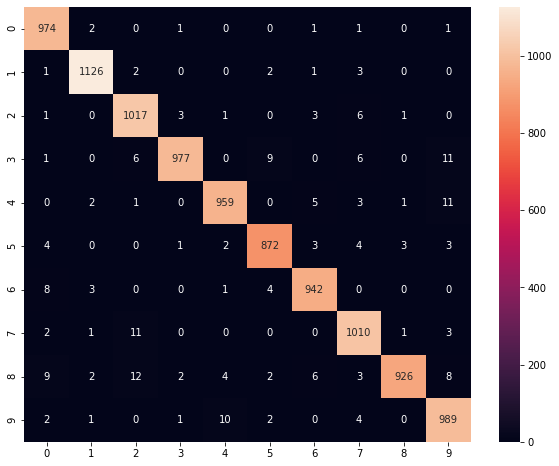

In [110]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx2, annot=True, fmt='g')

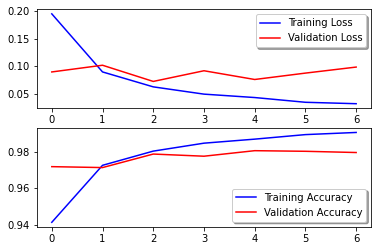

In [111]:
# Построим графики того как меняются значения loss-функции
# Также отметим одно наблюдение, что необходимо полностью перезапускать весь код, так как если выполнять повторно код где модель фитится, то точность подскакивает почти до 100%, моель явно переобучается
fig, ax = plt.subplots(2,1)
ax[0].plot(history_2.history['loss'], color='b', label="Training Loss")
ax[0].plot(history_2.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_2.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(history_2.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# Также наблюдаем оверфит вначале второй эпохи, но чтобы немного подятнуть точность повыше,специально указал параметры patience и min_delta чтобы не пустить оверфит далеко

# Test best model on my custom image

In [112]:
# Импортируем необходимые библиотеки для удобства работы с изображениями
from PIL import Image
import os
import imageio
import matplotlib.image as mpimg

In [113]:
# To load images to features and labels
def load_images_to_data(image_label, image_directory, features_data, label_data):
    list_of_files = os.listdir(image_directory)
    for file in list_of_files:
        image_file_name = os.path.join(image_directory, file)
        if ".png" in image_file_name:
            img = Image.open(image_file_name).convert("L")
            img = np.resize(img, (28,28,1))
            im2arr = np.array(img)
            im2arr = im2arr.reshape(1,28,28,1)
            features_data = np.append(features_data, im2arr, axis=0)
            label_data = np.append(label_data, [image_label], axis=0)
    return features_data, label_data

In [114]:
(X_train1, y_train1), (X_test1, y_test1) = mnist.load_data()

In [115]:
# Сделаем reshaping нашего датасета и потом выполним загрузку собственных изображений. После этого сделаем нормализацию
X_train1 = X_train1.reshape(X_train1.shape[0], X_train1.shape[1], X_train1.shape[2], 1).astype('float32')
X_test1 = X_test1.reshape(X_test1.shape[0], X_test1.shape[1], X_test1.shape[2], 1).astype('float32')

In [116]:
# Загрузим наши собственные числа (нарисованные в paint online) - выберем например 3 числа - 8,  1 и 4 (более различимые друг от друга)
# Также предварительно сожмем наши фото до размерности 28 на 28 (при помощи онлайн интерфейса imageonline)

# для каждой из трех цифр нарисуем 15 картинок (10 для train и 5 для test).
# две картинки в каждом из датасетов будут особенные (одна написана специально справа, вторая слева, не по центру)
X_train1, y_train1 = load_images_to_data('8', 'Custom_image/Number_8/train_data', X_train1, y_train1)
X_test1, y_test1 = load_images_to_data('8', 'Custom_image/Number_8/validation_data', X_test1, y_test1)

X_train1, y_train1 = load_images_to_data('1', 'Custom_image/Number_1/train_data', X_train1, y_train1)
X_test1, y_test1 = load_images_to_data('1', 'Custom_image/Number_1/validation_data', X_test1, y_test1)

X_train1, y_train1 = load_images_to_data('4', 'Custom_image/Number_4/train_data', X_train1, y_train1)
X_test1, y_test1 = load_images_to_data('4', 'Custom_image/Number_4/validation_data', X_test1, y_test1)

In [117]:
# нормализируем наши данные
X_train1/=255
X_test1/=255

In [118]:
# сделаем one hot encoding
y_train1 = y_train1.reshape(-1, 1)
y_test1 = y_test1.reshape(-1, 1)

In [119]:
encoder_hot1 = preprocessing.OneHotEncoder()

encoder_hot1.fit(y_train1)
y_train1_tr = encoder_hot1.transform(y_train1).toarray()

encoder_hot.fit(y_test1)
y_test1_tr = encoder_hot1.transform(y_test1).toarray()

print(f'Value without encoding: {y_test1[123]}')
print(f'Value with encoding: {y_test1_tr[123]}')

Value without encoding: ['6']
Value with encoding: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [120]:
# используем нашу самую псоледнюю момдель с подобранными гипперпараметрами - model_2
history_2 = model_2.fit(X_train1, y_train1_tr,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
1689/1689 [==============================] - 17s 10ms/step - loss: 0.0311 - acc: 0.9910 - f1_m: 0.9910 - val_loss: 0.1458 - val_acc: 0.9765 - val_f1_m: 0.9755
Epoch 2/10
1689/1689 [==============================] - 17s 10ms/step - loss: 0.0264 - acc: 0.9929 - f1_m: 0.9929 - val_loss: 0.1960 - val_acc: 0.9748 - val_f1_m: 0.9738
Epoch 3/10
1689/1689 [==============================] - 17s 10ms/step - loss: 0.0295 - acc: 0.9919 - f1_m: 0.9920 - val_loss: 0.1839 - val_acc: 0.9760 - val_f1_m: 0.9749
Epoch 4/10
1689/1689 [==============================] - 17s 10ms/step - loss: 0.0240 - acc: 0.9938 - f1_m: 0.9938 - val_loss: 0.1601 - val_acc: 0.9795 - val_f1_m: 0.9787
Epoch 5/10
1689/1689 [==============================] - 18s 10ms/step - loss: 0.0267 - acc: 0.9934 - f1_m: 0.9934 - val_loss: 0.1895 - val_acc: 0.9767 - val_f1_m: 0.9757
Epoch 00005: early stopping


[8]


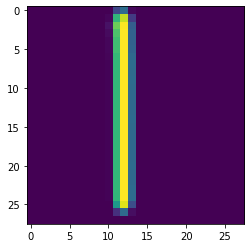

In [145]:
# Проверим, как предиктятся наши кастомные изображения
# Число 1
img = Image.open('Custom_image/Number_1/train_data/1_1.png').convert("L")
img = np.resize(img, (28,28,1))
im2arr = np.array(img)
im2arr = im2arr.reshape(1,28,28,1)

y_pred_num1 = model_2.predict(im2arr)
classes_num1=np.argmax(y_pred_num1,axis=1)
print(classes_num1)

plt.imshow(img)
plt.show()

[1]


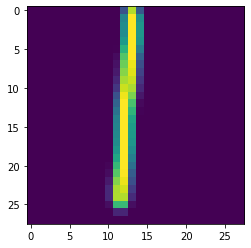

In [147]:
img = Image.open('Custom_image/Number_1/train_data/1_3.png').convert("L")
img = np.resize(img, (28,28,1))
im2arr = np.array(img)
im2arr = im2arr.reshape(1,28,28,1)

y_pred_num1 = model_2.predict(im2arr)
classes_num1=np.argmax(y_pred_num1,axis=1)
print(classes_num1)

plt.imshow(img)
plt.show()

[5]


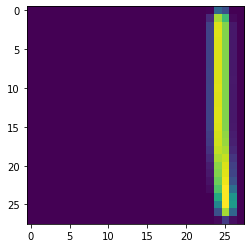

In [148]:
img = Image.open('Custom_image/Number_1/train_data/1_6.png').convert("L")
img = np.resize(img, (28,28,1))
im2arr = np.array(img)
im2arr = im2arr.reshape(1,28,28,1)

y_pred_num1 = model_2.predict(im2arr)
classes_num1=np.argmax(y_pred_num1,axis=1)
print(classes_num1)

plt.imshow(img)
plt.show()

[4]


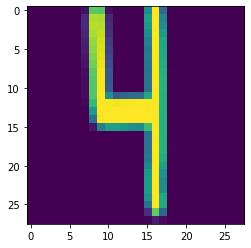

In [153]:
# Число 4
img = Image.open('Custom_image/Number_4/train_data/4_1.png').convert("L")
img = np.resize(img, (28,28,1))
im2arr = np.array(img)
im2arr = im2arr.reshape(1,28,28,1)

y_pred_num4 = model_2.predict(im2arr)
classes_num4=np.argmax(y_pred_num4,axis=1)
print(classes_num4)

plt.imshow(img)
plt.show()

[4]


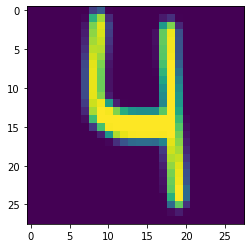

In [155]:
img = Image.open('Custom_image/Number_4/train_data/4_4.png').convert("L")
img = np.resize(img, (28,28,1))
im2arr = np.array(img)
im2arr = im2arr.reshape(1,28,28,1)

y_pred_num4 = model_2.predict(im2arr)
classes_num4=np.argmax(y_pred_num4,axis=1)
print(classes_num4)

plt.imshow(img)
plt.show()

[0]


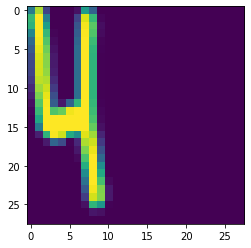

In [156]:
img = Image.open('Custom_image/Number_4/train_data/4_6.png').convert("L")
img = np.resize(img, (28,28,1))
im2arr = np.array(img)
im2arr = im2arr.reshape(1,28,28,1)

y_pred_num4 = model_2.predict(im2arr)
classes_num4=np.argmax(y_pred_num4,axis=1)
print(classes_num4)

plt.imshow(img)
plt.show()

[2]


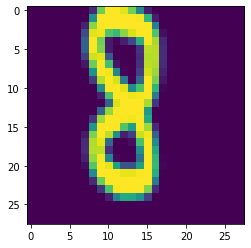

In [157]:
# Число 8
img = Image.open('Custom_image/Number_8/train_data/8_1.png').convert("L")
img = np.resize(img, (28,28,1))
im2arr = np.array(img)
im2arr = im2arr.reshape(1,28,28,1)

y_pred_num8 = model_2.predict(im2arr)
classes_num8=np.argmax(y_pred_num8,axis=1)
print(classes_num8)

plt.imshow(img)
plt.show()

[8]


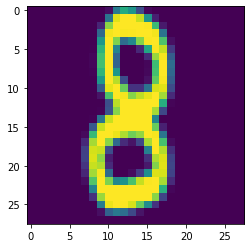

In [159]:
img = Image.open('Custom_image/Number_8/train_data/8_2.png').convert("L")
img = np.resize(img, (28,28,1))
im2arr = np.array(img)
im2arr = im2arr.reshape(1,28,28,1)

y_pred_num8 = model_2.predict(im2arr)
classes_num8=np.argmax(y_pred_num8,axis=1)
print(classes_num8)

plt.imshow(img)
plt.show()

[7]


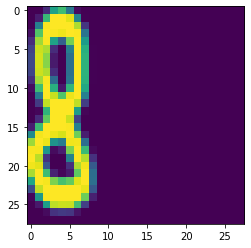

In [161]:
img = Image.open('Custom_image/Number_8/train_data/8_8.png').convert("L")
img = np.resize(img, (28,28,1))
im2arr = np.array(img)
im2arr = im2arr.reshape(1,28,28,1)

y_pred_num8 = model_2.predict(im2arr)
classes_num8=np.argmax(y_pred_num8,axis=1)
print(classes_num8)

plt.imshow(img)
plt.show()

In [ ]:
# Итого выводы по предиктам по кастомым фоткам: Число 4 по центру предсказывается очень хорошо, правда 1 и 8 с переменным успехом, но больше в худшую сторону
# Числа, нарисованные не по центру вообще нормально не предиктятся. Предполагаю, что здесь нужно создавать совсем новую модель со специализированными скрытыми слоями, чтобы настроить распознование цифр не по центру
# Также мне кажется, что ошибки в предсказании числа 1 и 8 у меня из за какой то ошибки предобработки изображений